<a href="https://www.kaggle.com/code/yasinsoylu123/traffic-signal-cnn-resnet?scriptVersionId=111786850" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/traffic-signs-preprocessed/mean_image_rgb.pickle
/kaggle/input/traffic-signs-preprocessed/data5.pickle
/kaggle/input/traffic-signs-preprocessed/data4.pickle
/kaggle/input/traffic-signs-preprocessed/data7.pickle
/kaggle/input/traffic-signs-preprocessed/data8.pickle
/kaggle/input/traffic-signs-preprocessed/data1.pickle
/kaggle/input/traffic-signs-preprocessed/data3.pickle
/kaggle/input/traffic-signs-preprocessed/test.pickle
/kaggle/input/traffic-signs-preprocessed/mean_image_gray.pickle
/kaggle/input/traffic-signs-preprocessed/data6.pickle
/kaggle/input/traffic-signs-preprocessed/data0.pickle
/kaggle/input/traffic-signs-preprocessed/valid.pickle
/kaggle/input/traffic-signs-preprocessed/data2.pickle
/kaggle/input/traffic-signs-preprocessed/labels.pickle
/kaggle/input/traffic-signs-preprocessed/datasets_preparing.py
/kaggle/input/traffic-signs-preprocessed/std_gray.pickle
/kaggle/input/traffic-signs-preprocessed/std_rgb.pickle
/kaggle/input/traffic-signs-preprocessed/label_na

In [2]:
import pandas as pd
import tensorflow as tf
import keras
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten,BatchNormalization, Dropout, Lambda, Conv2D, MaxPool2D
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten,BatchNormalization, Dropout, Lambda
import numpy as np
import matplotlib.pyplot as plt
import cv2




import warnings
# filter warnings
warnings.filterwarnings('ignore')

# DATA PRE-PROCESSING

In [3]:
data = pd.read_pickle("../input/traffic-signs-preprocessed/data8.pickle")


In [4]:
print("x train shape:", data["x_train"].shape)
print("y train shape:", data["y_train"].shape)
print("x test shape:", data["x_test"].shape)
print("y test shape:", data["y_test"].shape)
print("x validation shape:", data["x_validation"].shape)
print("y validation shape:", data["y_validation"].shape)

x train shape: (86989, 1, 32, 32)
y train shape: (86989,)
x test shape: (12630, 1, 32, 32)
y test shape: (12630,)
x validation shape: (4410, 1, 32, 32)
y validation shape: (4410,)


In [5]:
x_train = data["x_train"]
x_test = data["x_test"]
x_val = data["x_validation"]
y_train = data["y_train"]
y_val = data["y_validation"]

In [6]:
x_train = x_train.swapaxes(1,2)
x_train = x_train.swapaxes(2,3)

x_train.shape

(86989, 32, 32, 1)

In [7]:
x_val = x_val.swapaxes(1,2)
x_val = x_val.swapaxes(2,3)
print("x val shape:", x_val.shape)

x val shape: (4410, 32, 32, 1)


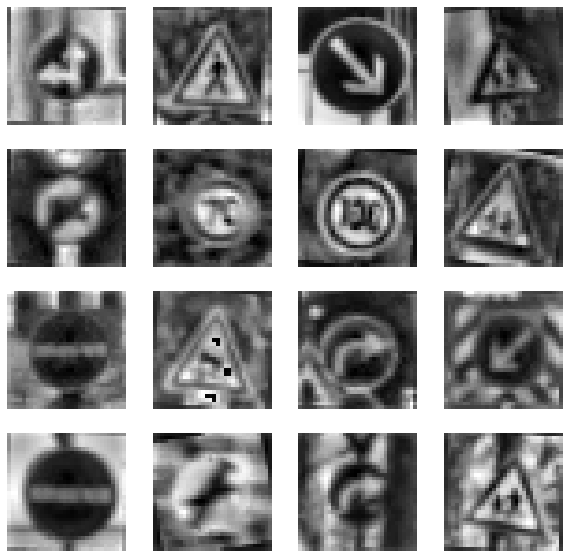

In [8]:
plt.figure(figsize=(10,10)) 

for i in range(16):
    plt.subplot(4,4,i+1)   
    plt.imshow(x_train[i], cmap = "gray")
    plt.axis("off")

plt.show()

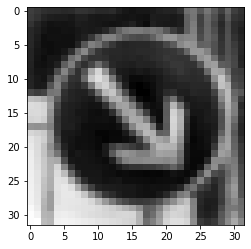

In [9]:
plt.imshow(x_train[2][:,:,0],cmap='gray')
plt.show()

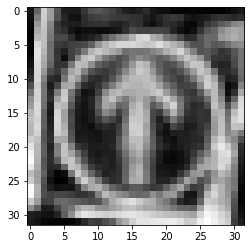

In [10]:
plt.imshow(x_train[18][:,:,0],cmap='gray')
plt.show()

In [11]:
def resize(img):
    numberofImage = img.shape[0]
    new_array = np.zeros((numberofImage,64,64,1))
    for i in range(numberofImage):
        new_array[i] = tf.image.resize(img[i],(64,64))
    return new_array

In [12]:
x_train = resize(x_train)
x_val = resize(x_val)
print("x train resized shape:", x_train.shape)
print("x validation resized shape:", x_val.shape)

2022-11-22 19:41:09.658442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 19:41:09.794176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 19:41:09.794981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 19:41:09.800048: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

x train resized shape: (86989, 64, 64, 1)
x validation resized shape: (4410, 64, 64, 1)


In [13]:
NumberofClass = 43
y_train = to_categorical(y_train, num_classes = NumberofClass)
y_val = to_categorical(y_val, num_classes = NumberofClass)

In [14]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%  0,1 best
        width_shift_range=0.1,  # randomly shift images horizontally 10%  +++
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

# CNN

In [15]:
model = Sequential()


model.add(Conv2D(filters = 128, kernel_size = (4,4), padding = "Same", activation = "relu", input_shape = (64,64,1)))

model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (4,4), padding = "Same", activation = "relu" ))

model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 32, kernel_size = (4,4), padding = "Same", activation = "relu" ))

model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 16, kernel_size = (4,4), padding = "Same", activation = "relu" ))

model.add(MaxPool2D(pool_size = (2,2)))

model.add(Flatten())

model.add(Dense(units = 512, activation = "relu"))

model.add(Dropout(0.5))

model.add(Dense(units = NumberofClass, activation = "softmax"))

model.compile(optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       2176      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        131136    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        32800     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          8

In [16]:
epochs = 10  # for better result increase the epochs
batch_size = 250

In [17]:
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val))

2022-11-22 19:42:09.012970: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-11-22 19:42:10.580111: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


348/348 [==============================] - 55s 135ms/step - loss: 1.9465 - accuracy: 0.4457 - val_loss: 0.5868 - val_accuracy: 0.8222
Epoch 2/10
348/348 [==============================] - 46s 131ms/step - loss: 0.5689 - accuracy: 0.8280 - val_loss: 0.1917 - val_accuracy: 0.9383
Epoch 3/10
348/348 [==============================] - 46s 133ms/step - loss: 0.2790 - accuracy: 0.9175 - val_loss: 0.1119 - val_accuracy: 0.9660
Epoch 4/10
348/348 [==============================] - 45s 130ms/step - loss: 0.1850 - accuracy: 0.9455 - val_loss: 0.0900 - val_accuracy: 0.9717
Epoch 5/10
348/348 [==============================] - 46s 131ms/step - loss: 0.1435 - accuracy: 0.9575 - val_loss: 0.0666 - val_accuracy: 0.9789
Epoch 6/10
348/348 [==============================] - 46s 131ms/step - loss: 0.1177 - accuracy: 0.9645 - val_loss: 0.0567 - val_accuracy: 0.9866
Epoch 7/10
348/348 [==============================] - 46s 131ms/step - loss: 0.1049 - accuracy: 0.9685 - val_loss: 0.0548 - val_accuracy: 0.9

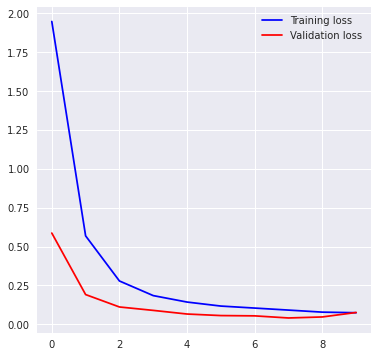

<Figure size 576x396 with 0 Axes>

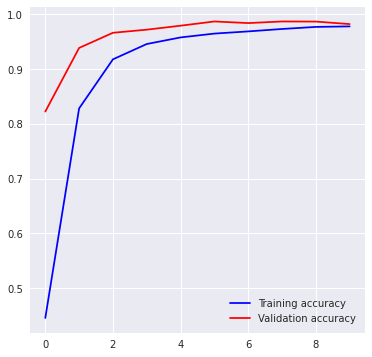

In [18]:
plt.style.use('seaborn')
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.show()

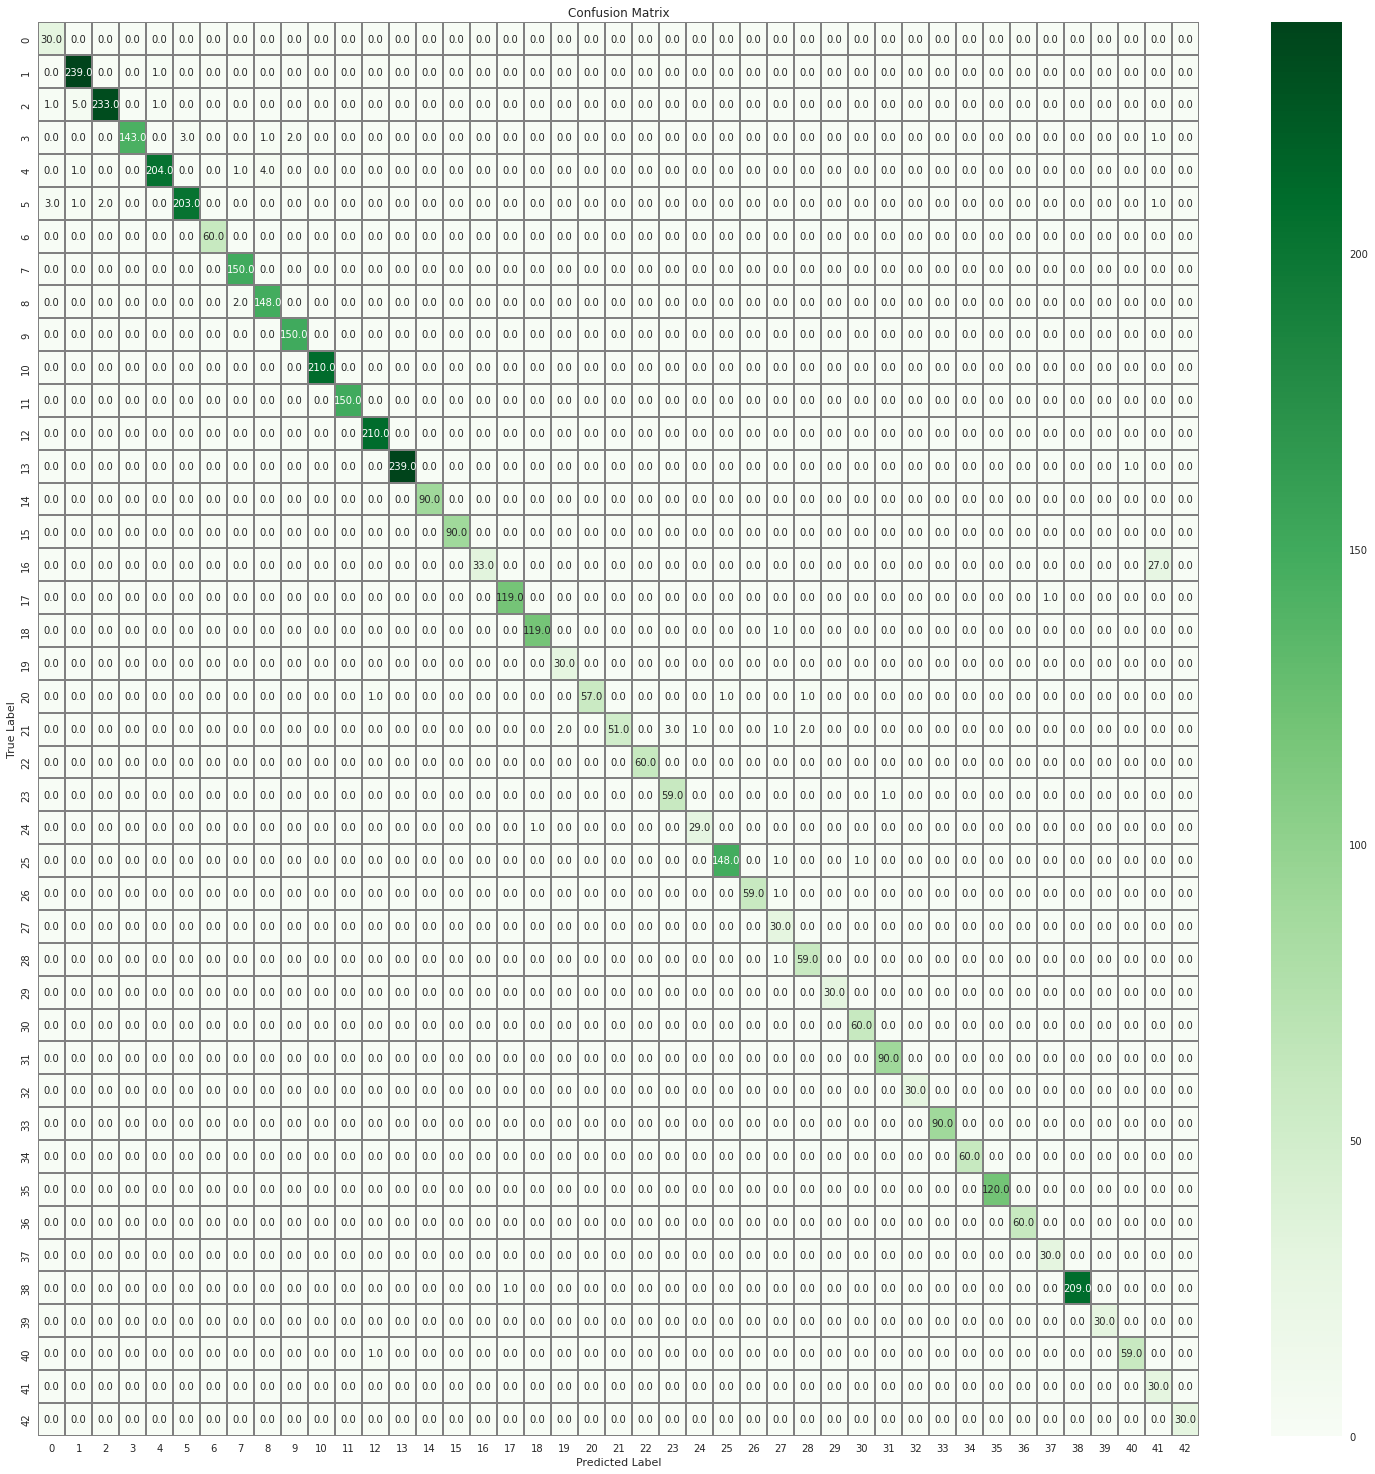

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(26, 26))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ResNet50

# DATA PRE-PROCESSING

In [20]:
data = pd.read_pickle('/kaggle/input/traffic-signs-preprocessed/data0.pickle')

In [21]:
x_train = data['x_train']
x_validation = data['x_validation']

In [22]:
numberOfClass = 43

def preprocess_data(x,y):
    x_data = preprocess_input(x)
    y_data = to_categorical(y, numberOfClass)
    return x_data, y_data

In [23]:
x_train = x_train.swapaxes(1,2)
x_train = x_train.swapaxes(2,3)

In [24]:
x_validation = x_validation.swapaxes(1,2)
x_validation = x_validation.swapaxes(2,3)

In [25]:
x_train, y_train = preprocess_data(x_train, data['y_train'])
x_validation, y_validation = preprocess_data(x_validation, data['y_validation'])

# ResNet50

In [26]:
import warnings
# filter warnings
warnings.filterwarnings('ignore')


resnet_model = ResNet50(include_top = False, weights = "imagenet", input_shape = (224,224,3))


94781440/94765736 [==============================] - 4s 0us/step


In [27]:
print(resnet_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [28]:
for layer in resnet_model.layers:
    layer.trainable = False

In [29]:
img_size = (224,224)

model = Sequential() 
model.add(Lambda(lambda image: tf.image.resize(image,img_size)))
model.add(resnet_model)

# Fully connected layer
model.add(Flatten()) 
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass, activation='softmax'))


model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])


In [30]:
epochs = 10  # for better result increase the epochs
batch_size = 1000

In [31]:
import warnings
# filter warnings
warnings.filterwarnings('ignore')

hist = model.fit(x_train, y_train, validation_data =(x_validation,y_validation), epochs = epochs, batch_size = batch_size)

2022-11-22 19:50:46.629813: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1068920832 exceeds 10% of free system memory.
2022-11-22 19:50:47.810522: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1068920832 exceeds 10% of free system memory.


Epoch 1/10
87/87 [==============================] - 133s 1s/step - loss: 5.8475 - accuracy: 0.2034 - val_loss: 1.7478 - val_accuracy: 0.5014
Epoch 2/10
87/87 [==============================] - 122s 1s/step - loss: 1.2640 - accuracy: 0.6368 - val_loss: 0.7663 - val_accuracy: 0.7649
Epoch 3/10
87/87 [==============================] - 122s 1s/step - loss: 0.5496 - accuracy: 0.8422 - val_loss: 0.6913 - val_accuracy: 0.8177
Epoch 4/10
87/87 [==============================] - 122s 1s/step - loss: 0.3173 - accuracy: 0.9108 - val_loss: 0.6255 - val_accuracy: 0.8390
Epoch 5/10
87/87 [==============================] - 122s 1s/step - loss: 0.2209 - accuracy: 0.9391 - val_loss: 0.5139 - val_accuracy: 0.8823
Epoch 6/10
87/87 [==============================] - 122s 1s/step - loss: 0.1687 - accuracy: 0.9542 - val_loss: 0.5164 - val_accuracy: 0.8887
Epoch 7/10
87/87 [==============================] - 122s 1s/step - loss: 0.1402 - accuracy: 0.9628 - val_loss: 0.4915 - val_accuracy: 0.8882
Epoch 8/10
87

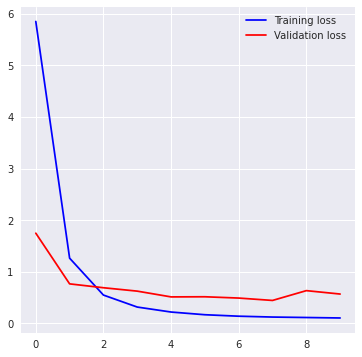

<Figure size 576x396 with 0 Axes>

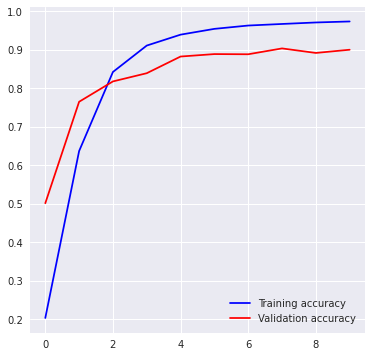

In [32]:
plt.style.use('seaborn')
plt.figure(figsize=(6,6))
plt.plot(hist.history['loss'], color='b', label="Training loss")
plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(6,6))
plt.plot(hist.history['accuracy'], color='b', label="Training accuracy")
plt.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.show()

In [33]:
loss,accuracy=model.evaluate(x_validation,y_validation)


138/138 [==============================] - 8s 54ms/step - loss: 0.5692 - accuracy: 0.9000


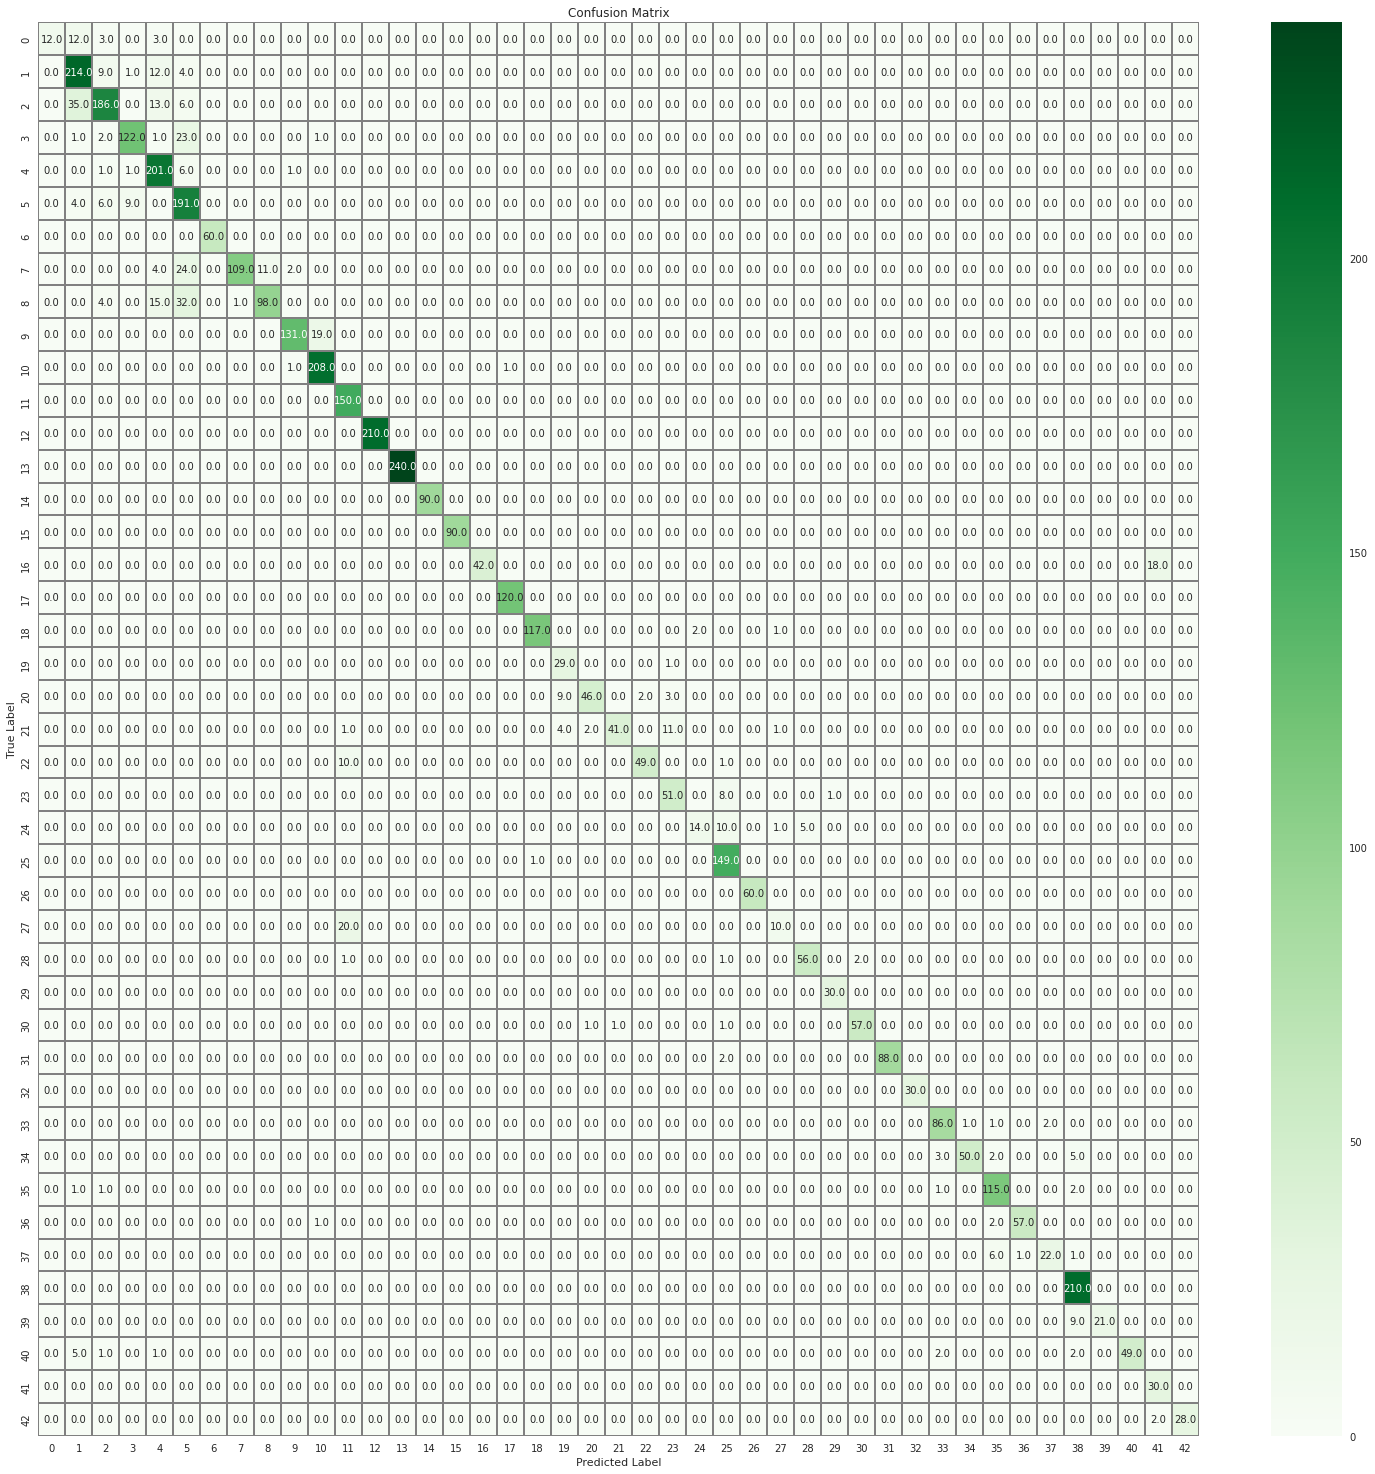

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(x_validation)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(26, 26))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [35]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.40      0.57        30
           1       0.79      0.89      0.84       240
           2       0.87      0.78      0.82       240
           3       0.92      0.81      0.86       150
           4       0.80      0.96      0.87       210
           5       0.67      0.91      0.77       210
           6       1.00      1.00      1.00        60
           7       0.99      0.73      0.84       150
           8       0.90      0.65      0.76       150
           9       0.97      0.87      0.92       150
          10       0.91      0.99      0.95       210
          11       0.82      1.00      0.90       150
          12       1.00      1.00      1.00       210
          13       1.00      1.00      1.00       240
          14       1.00      1.00      1.00        90
          15       1.00      1.00      1.00        90
          16       1.00      0.70      0.82        60
          17       0.99    

In [36]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])

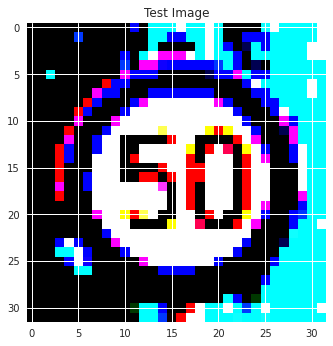

In [37]:
index1 = 70

img_plot(x_validation, index1)

In [38]:
input1 = x_validation[index1:index1+1]
print('Input Index =',index1)

Input Index = 70


In [39]:
pred1 = model.predict(input1)[0].argmax()
label1 = y_validation[index1].argmax()

In [40]:
print('Predicted Value using  cnn model',pred1)
print("True Value",label1)

Predicted Value using  cnn model 2
True Value 2
